In [1]:
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from zipfile import ZipFile
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
with ZipFile('faang.zip') as zipFile:
    df = pd.read_csv(zipFile.open('Facebook_Historical_StockPrice2.csv'))
df['Date'] = pd.to_datetime(df.Date, format='%Y-%m-%d')
# df = df.set_index(['date'])
# df.sort_index(inplace=True)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1260 non-null   float64       
 2   High       1260 non-null   float64       
 3   Low        1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Adj Close  1260 non-null   float64       
 6   Volume     1260 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 69.0 KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,113.320000,114.589996,112.949997,113.690002,113.690002,21351800
1,2016-03-29,113.830002,116.320000,113.639999,116.139999,116.139999,29825300
2,2016-03-30,116.730003,116.989998,114.360001,114.699997,114.699997,33235200
3,2016-03-31,114.699997,115.010002,113.769997,114.099998,114.099998,21207500
4,2016-04-01,113.750000,116.169998,113.349998,116.059998,116.059998,24760500


In [3]:
df['DateWeek']  = df['Date'] - pd.to_timedelta(df['Date'].dt.dayofweek, unit='d')
df['DateMonth'] = df['Date'] + pd.offsets.MonthBegin(-1)

In [10]:
df.groupby(['DateWeek']).head(20)
# df.head(20)

,Date,Open,High,Low,Close,Adj Close,Volume,DateWeek,DateMonth
0,2016-03-28,113.320000,114.589996,112.949997,113.690002,113.690002,21351800,2016-03-28,2016-03-01
1,2016-03-29,113.830002,116.320000,113.639999,116.139999,116.139999,29825300,2016-03-28,2016-03-01
2,2016-03-30,116.730003,116.989998,114.360001,114.699997,114.699997,33235200,2016-03-28,2016-03-01
3,2016-03-31,114.699997,115.010002,113.769997,114.099998,114.099998,21207500,2016-03-28,2016-03-01
4,2016-04-01,113.750000,116.169998,113.349998,116.059998,116.059998,24760500,2016-03-28,2016-03-01
...,...,...,...,...,...,...,...,...,...
1255,2021-03-22,290.450012,299.709991,286.750000,293.540009,293.540009,28273100,2021-03-22,2021-03-01
1256,2021-03-23,293.149994,298.000000,289.809998,290.630005,290.630005,23000900,2021-03-22,2021-03-01
1257,2021-03-24,291.000000,291.720001,281.160004,282.140015,282.140015,18675000,2021-03-22,2021-03-01
1258,2021-03-25,280.980011,288.059998,277.750000,278.739990,278.739990,24505600,2021-03-22,2021-03-01


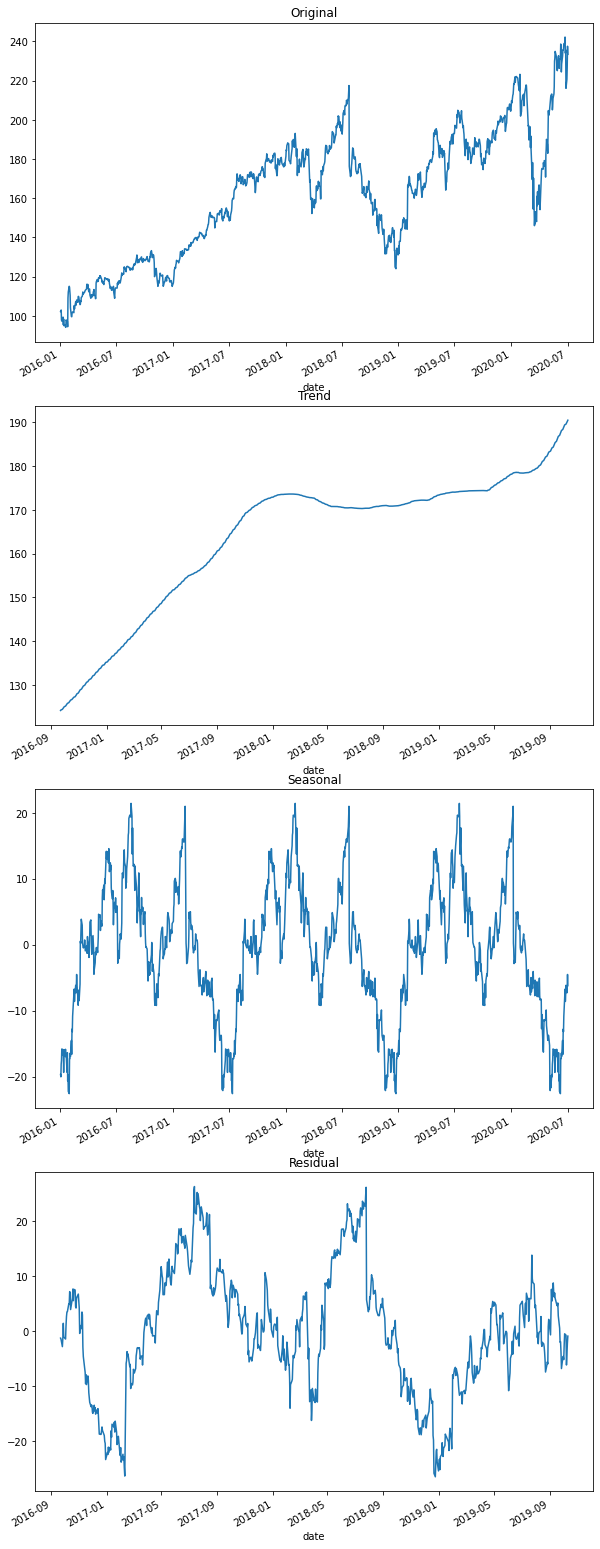

In [35]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10, 30))
decompose = seasonal_decompose(df[[company]], period=365)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

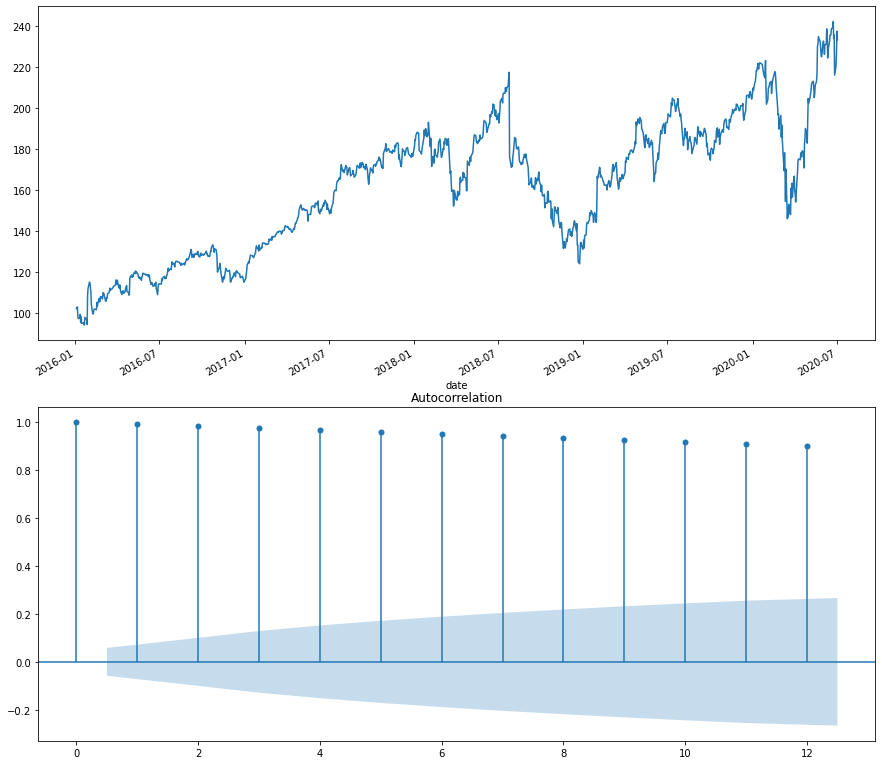

In [45]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df[company].plot(ax=ax[0])
plot_acf(df[company], lags=12, ax=ax[1]);

In [47]:
p_value = adfuller(df[company])[1]
print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.')

Полученный уровень значимости (p-value): 0.4158.


In [58]:
regression_df = df.copy()
regression_df = regression_df.drop(regression_df.columns.difference([company]), axis=1)
regression_df.head()

,FB
date,
2016-01-04,102.220001
2016-01-05,102.730003
2016-01-06,102.970001
2016-01-07,97.919998
2016-01-08,97.330002


In [61]:
X = regression_df.to_numpy()[:-1, :]
y = np.squeeze(regression_df.to_numpy()[1:])

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

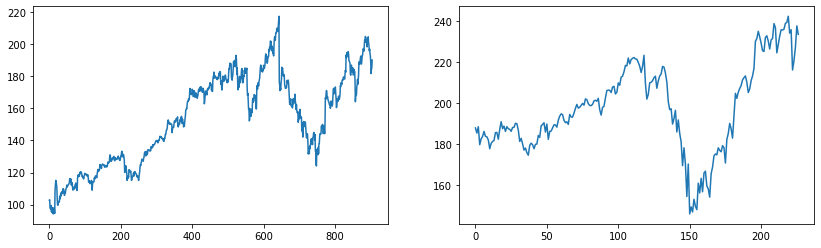

In [64]:
plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 4))

ax = plt.subplot(121)
ax.plot(y_train)

ax = plt.subplot(122)
ax.plot(y_test);

In [65]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
linear_regression.coef_

array([0.99380482])

In [66]:
def make_prediction(regressor, starting_point, predictions_count):
    point = copy.deepcopy(starting_point)
    
    predicted_points = [point]
    
    for _ in range(predictions_count):
        predicted_value = regressor.predict([predicted_points[-1]])[0]
        predicted_point = [predicted_value]
        predicted_points.append(np.array(predicted_point, dtype=np.float64))
    
    return np.array(predicted_points, dtype=np.float64)

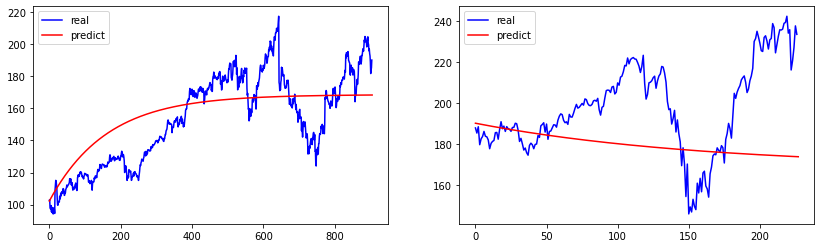

In [68]:
plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(14, 4))


ax = plt.subplot(121)
ax.plot(y_train, c='b', label='real')
ax.plot(make_prediction(linear_regression, X_train[0], y_train.shape[0]), c='r', label='predict')
ax.legend()

ax = plt.subplot(122)
ax.plot(y_test, c='b', label='real')
ax.plot(make_prediction(linear_regression, X_test[0], y_test.shape[0])[:, 0], c='r', label='predict')
ax.legend();

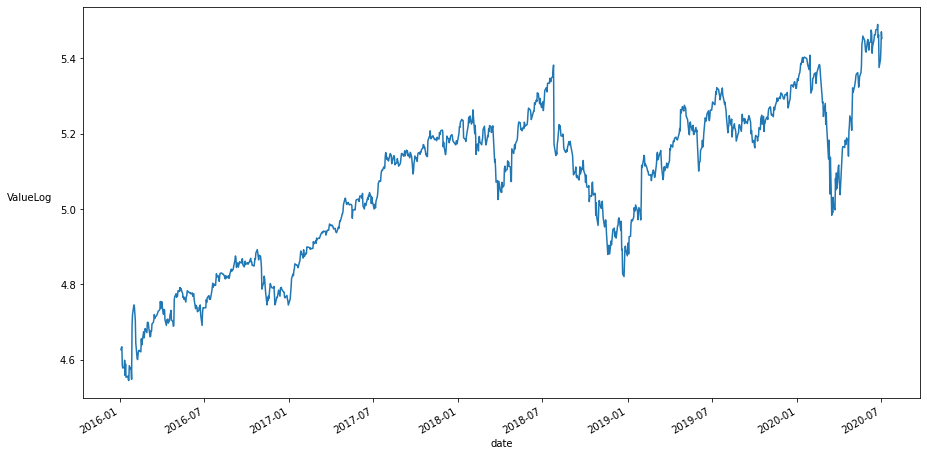

In [70]:
sarima_df = df.copy()
sarima_df = sarima_df.drop(regression_df.columns.difference([company]), axis=1)
sarima_df['ValueLog'] = np.log(df[company])

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLog', rotation=0, labelpad=30)
sarima_df['ValueLog'].plot();

Полученный уровень значимости (p-value): 0.0.


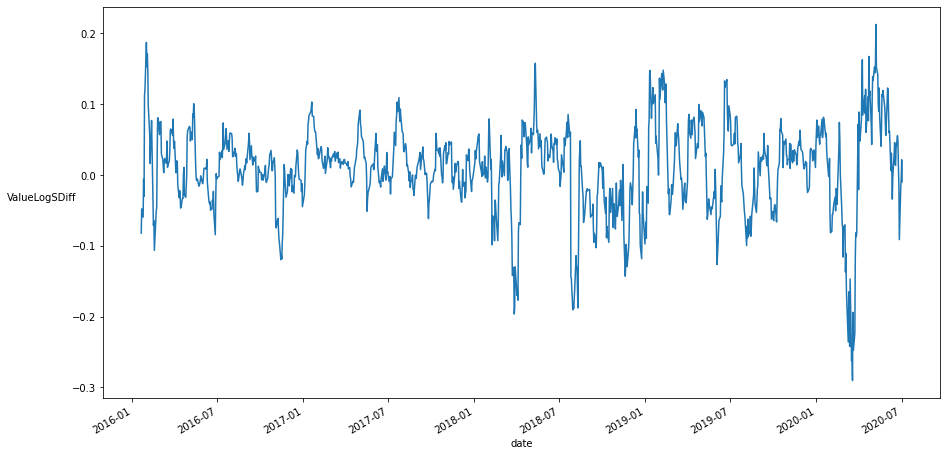

In [72]:
sarima_df['ValueLogSDiff'] = sarima_df['ValueLog'] - sarima_df['ValueLog'].shift(12)
p_value = adfuller(sarima_df["ValueLogSDiff"][12:])[1]

print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.')

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLogSDiff', rotation=0, labelpad=30)
sarima_df['ValueLogSDiff'].plot();

Полученный уровень значимости (p-value): 0.0.


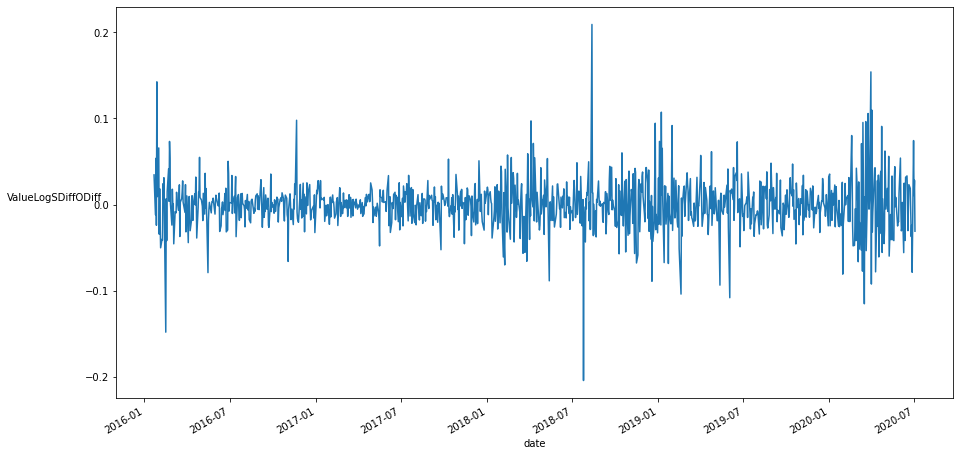

In [73]:
sarima_df['ValueLogSDiffODiff'] = sarima_df['ValueLogSDiff'] - sarima_df['ValueLogSDiff'].shift(1)
p_value = adfuller(sarima_df["ValueLogSDiffODiff"][13:])[1]

print(f'Полученный уровень значимости (p-value): {round(p_value, 4)}.')

plt.figure(figsize=(15, 8))
plt.ylabel('ValueLogSDiffODiff', rotation=0, labelpad=30)
sarima_df['ValueLogSDiffODiff'].plot();

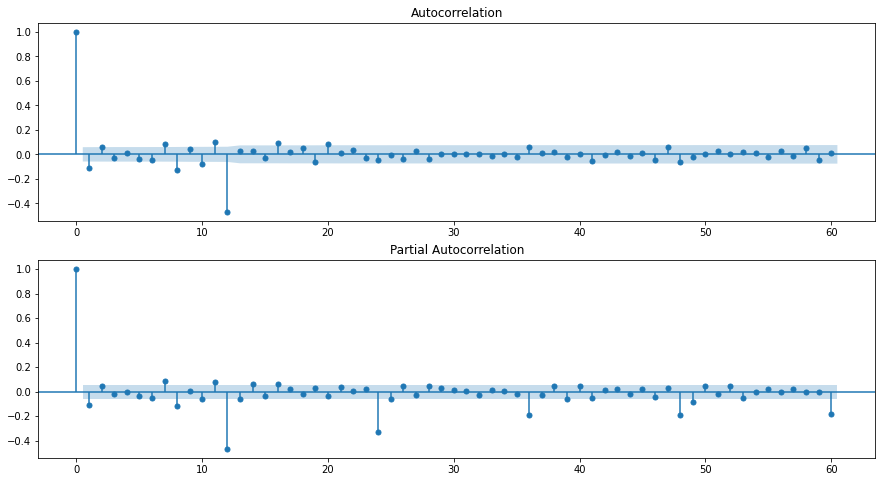

In [74]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(sarima_df['ValueLogSDiffODiff'][13:], lags=60, ax=ax)

ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(sarima_df['ValueLogSDiffODiff'][13:], lags=60, ax=ax);

In [75]:
d=1
D=1

qs = range(1, 5)
Qs = range(1, 3)

ps = range(1, 5)
Ps = range(3, 5)

In [76]:
from itertools import product
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [77]:
%%time
#warnings.filterwarnings('ignore')
import statsmodels.api as sm


results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            sarima_df['ValueLog'], 
            order=(param[0], d, param[1]), 
            seasonal_order=(param[2], D, param[3], 12)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

#warnings.filterwarnings('default')

  0%|          | 0/64 [00:00<?, ?it/s]/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
  2%|▏         | 1/64 [00:30<31:34, 30.08s/it]/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information

 17%|█▋        | 11/64 [08:08<41:21, 46.82s/it]/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
 19%|█▉        | 12/64 [09:59<57:17, 66.11s/it]/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:5

/home/td2r/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 34%|███▍      | 22/64 [18:31<39:01, 55.76s/it]/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 36%|███▌      | 23/64 [1

/home/td2r/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 52%|█████▏    | 33/64 [29:19<29:14, 56.58s/it]/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
 53%|█████▎    | 34/64 [30:03<26:25, 52.85s/it]/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency i

/home/td2r/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 69%|██████▉   | 44/64 [39:54<21:06, 63.31s/it]/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 70%|███████   | 45/64 [4

/home/td2r/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 86%|████████▌ | 55/64 [50:55<09:09, 61.09s/it]/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/td2r/.local/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
 88%|████████▊ | 56/64 [5

CPU times: user 2h 43min 10s, sys: 5h 11min 30s, total: 7h 54min 41s
Wall time: 1h 32s


In [79]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
0   (1, 1, 3, 1) -5484.300863
1   (1, 1, 3, 2) -5482.260197
13  (1, 4, 3, 2) -5482.136074
4   (1, 2, 3, 1) -5481.193983
5   (1, 2, 3, 2) -5480.578954


In [80]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           ValueLog   No. Observations:                 1133
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 12)   Log Likelihood                2749.150
Date:                            Thu, 04 Nov 2021   AIC                          -5484.301
Time:                                    03:44:55   BIC                          -5449.153
Sample:                                         0   HQIC                         -5471.016
                                           - 1133                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4226      0.168     -2.509      0.012      -0.753      -0.093
ma.L1          0.3267      0.176   

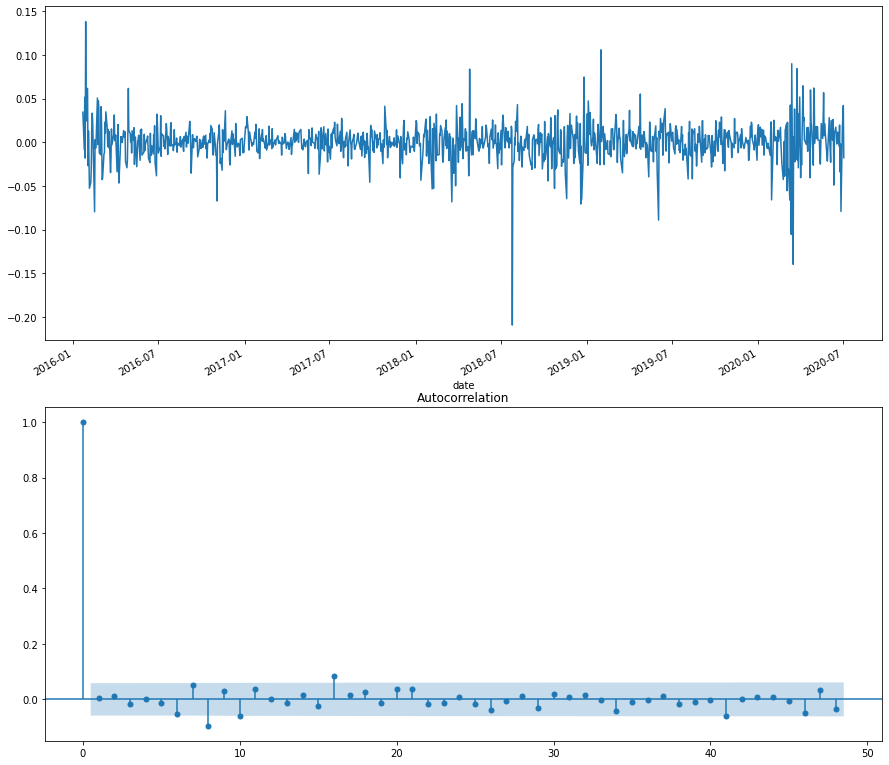

In [81]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid[13:].plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax);

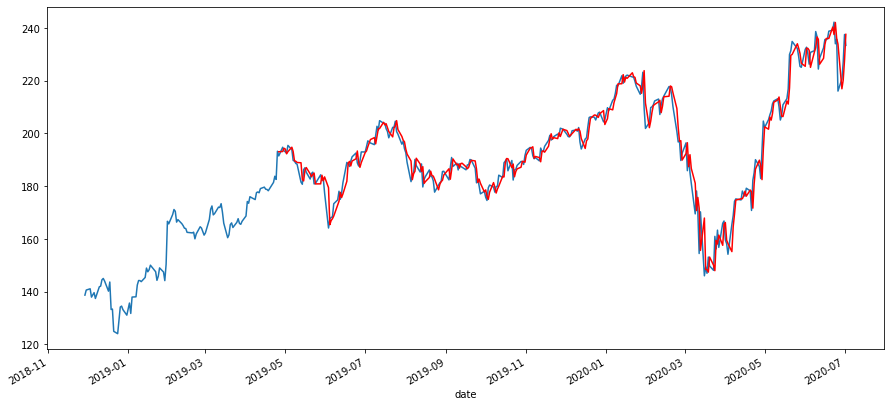

In [84]:
sarima_df['Model'] = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15,7))

sarima_df[company][-400:].plot()
sarima_df['Model'][-300:].plot(c='r');

In [86]:
print(sarima_df.shape)
sarima_df.tail()

(1133, 171)


,MSFT,AAPL,AMZN,GOOG,FB,INTC,CSCO,CMCSA,PEP,NFLX,...,MKTX,QGEN,LKQ,STLD,ALNY,CACC,ValueLog,ValueLogSDiff,ValueLogSDiffODiff,Model
date,,,,,,,,,,,,,,,,,,,,,
2020-06-26,196.330002,353.630005,2692.870117,1359.900024,216.080002,57.500000,45.32,38.421715,128.929993,453.720001,...,489.829987,43.500000,25.93,27.17,151.899994,411.100006,5.375649,-0.091272,-0.078665,233.895308
2020-06-29,198.440002,361.779999,2680.379883,1394.969971,220.639999,58.270000,45.32,38.709999,131.080002,453.720001,...,498.609985,43.160000,25.93,27.17,147.910004,420.160004,5.396532,-0.017031,0.074240,216.943054
2020-06-30,203.509995,364.799988,2758.820068,1413.609985,227.070007,59.830002,45.32,38.980000,132.259995,453.720001,...,500.920013,42.810001,25.93,27.17,148.110001,419.010010,5.425258,-0.006628,0.010404,220.271295
2020-07-01,204.699997,364.109985,2878.699951,1438.040039,237.550003,58.810001,45.32,39.700001,132.360001,453.720001,...,506.010010,42.709999,25.93,27.17,148.770004,420.399994,5.470378,0.021488,0.028116,227.765642
2020-07-02,206.259995,364.109985,2890.300049,1464.699951,233.419998,59.130001,45.32,39.250000,132.850006,453.720001,...,501.880005,42.509998,25.93,27.17,149.869995,421.809998,5.452839,-0.009508,-0.030996,237.601736


In [89]:
predict_len = 120

new_close_value = sarima_df[[company, 'Model']]
future_date = [
    datetime.datetime.strptime("2018-02-01", "%Y-%m-%d") + relativedelta(months=x)
    for x in range(0, predict_len)
]

future_sarima_df = pd.DataFrame(index=future_date, columns=[company, 'Model'])
new_close_value = pd.concat([new_close_value, future_sarima_df])

print(new_close_value.shape)
new_close_value.tail()

(1253, 2)


,FB,Model
2027-09-01,NaN,NaN
2027-10-01,NaN,NaN
2027-11-01,NaN,NaN
2027-12-01,NaN,NaN
2028-01-01,NaN,NaN


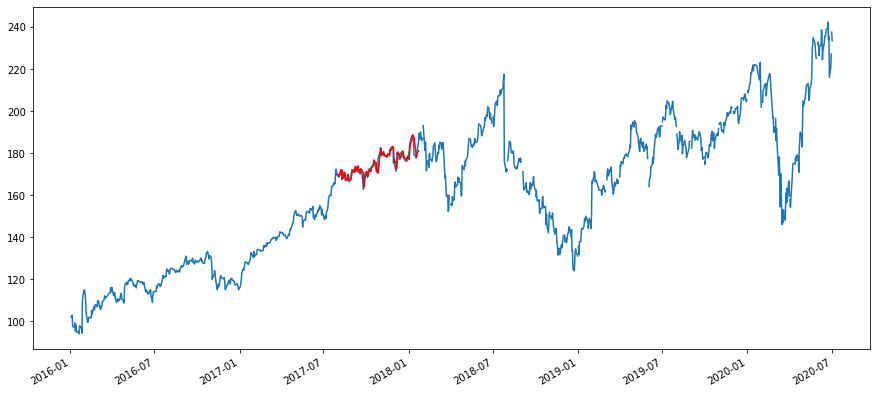

In [91]:
new_close_value['Model'] = np.exp(best_model.predict(start=397, end=397 + predict_len - 1))

plt.figure(figsize=(15,7))
new_close_value[company].plot()
new_close_value['Model'].plot(c='r');